# Two Layer Neural Network = One Hidden Layer Neural Network

## Learning Objective 
1. Understanding how the neural network work 
2. Implement a simple neural network 
3. Understand role of different tuning parameters 
4. Understand the effect of Regularization 
5. Using the network for digit recognition task

## Problem Definition


### Implementation 
We have to perform 3 tasks with this network - 
1. Separation of linear data  
2. Separation of non-linear data  
3. Digit recognition

We will implement a simple 2 layer neural network with following specification. 
1. Layer 1 :   
    Input = Number of features  
    Output = Number of nodes in hidden layer  
    Activation function = Sigmoid  
    
2. Layer 2 :   
    Input = Number of nodes in hidden layer   
    Output = Number of dimensions in the output = number of classes in y  
    Activation function = None  
    The ouput will be passed through softmax function to intepret the output as probabilities  
    
### Limitations
This neural network will introduce some non-linearity in the analysis but it will not be scalable. The network will also not be able to We will be hard coding the forward and backward propagation steps in the neural network.  

This neural network will only be able to understand the very simple non-linear functions. As we are using only 1 hidden layer, the network can introuce only 1 layer of non-linearity in the network. To calculate more complex function, we can select a network with more number of nodes in hidden layer, but a better way to go about it to introduce more layers in the network. 

### Explorations
Hyperparameters for the network :  
1. Number of nodes in the hidden layer  
2. Learning Rate   
3. Number of Epochs  

We will also understand the effect of these hyperparameters on our network by analysing the test error and train error in our network. 

In [11]:
# Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Helper Functions 

1.sig : Gives the sigmoid of the input array ( calculated as f(z) = 1/(1+e^(-z)) )  
2.softmax : Gives the softmax of the input array ( calculated as f(z) = [e^(z1)/ sum(e^(zi), e^(z1)/ sum(e^(zi),....]  
3.softmax_to_y : Input softmax vector and returns the most probable class      
4.split : Splits the dataframe into k parts ( both X and y) and returns a list  
5.cross validation : Performs cross validation by spliting the dataset into test, train. Returns the average of test_error and train_error from the dataset   
6.plot_decision_boundary : Plots the decision boundary in 2D space. Can only be used when inoput is 2 dimensional.  
7.error_rate : Returns the ratio of misclassified points   

In [12]:
def softmax(z):
    exp_z = np.exp(z)
    softmax_scores = exp_z / np.sum(exp_z, axis=1, keepdims=True)
    return softmax_scores

def sig(z):
    sig_z = np.exp(z)/(1+np.exp(z))
    return sig_z;

def softmax_to_y(softmax_scores):
    return np.argmax(softmax_scores, axis=1)

def error_rate(y_pred, y_test):
    m = y_pred.shape[0]
    return np.sum(1 - (y_pred == y_test))/m

def split_k(X,y,k):
    #Divides that data set in test and train dataset
    X_split = np.array_split(X,k)
    y_split = np.array_split(y,k)
    return [X_split, y_split]

def k_fold_cross(X,y,k, nodes, num_epochs, alpha ):
    X,y = split_k(X,y,k)
    test_error = [None]*(k)

    for i in range(k):
        b = 0 
        for j in range(k):
            if ( j == i):
                X_test = X[i]
                y_test = y[i]
            else:
                if(b == 0):
                    X_train = X[j]
                    y_train = y[j]
                    b+=1
                else:
                    X_train = np.concatenate([X_train,X[i]])
                    y_train = np.concatenate([y_train,y[i]])
        nn = one_layer_nn(input_dim, nodes, output_dim, alpha , num_epochs)
        nn.fit(X_train, y_train)
        y_pred = nn.predict(X_test)
        test_error[i] = error_rate(y_pred, y_test)
    return (np.sum(test_error)/(k+1))

def plot_decision_boundary(model, X, y):
    x1_array, x2_array = np.meshgrid(np.arange(-10, 10, 0.01), np.arange(-10, 10, 0.01))
    grid_coordinates = np.c_[x1_array.ravel(), x2_array.ravel()]
    Z = nn.predict(grid_coordinates)
    Z = Z.reshape(x1_array.shape)
    plt.contourf(x1_array, x2_array, Z, cmap=plt.cm.bwr)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr)
    plt.show()


### Implementation of neural network

Functions used for the implementation :
1. forward_prop : Input is the feature vector. Equations :   
        sig_h = W_1 * X + b_1    
        o__h  = 1 / ( 1 + e^(sig_h))  
        sig_f = W_2 * o_h + b_2  
        o_f   = softmax(sig_f)  
    Output of this function is the activations in the layer . We will cache these so that we can use it in backpropargation.   
2. gradient_desc :  Input is the activation cache from forward prop, X ( feature vectors ) and y ( output vector). We backpropagate the derivates backward. Using the cross entropy loss and softmax function in the final layer, we get 
    
        dp/d o_f = o_f - y {where o_f is the softmax score}     ..... eq 1   
        This has been implemented in the error_calc function
        
        dp/d w2  = eq 1 * d o_f /d sig_f * d sig_f/d w2
        and so on.  
        This has been implemented within the gradient descent function 
    
3. update_weight : This will update the weight in the previous epoch with learning rate * gradient . This directly updates the weight and bias terms in the neural network.  
    
4. predict : This is used after the neural network has been trained.  
5. hyperpara : This sets the hyperparameters in the neural network which will be used in the network
        

In [13]:
class one_layer_nn():

    #Initialization of weights
    def __init__(self,input_dim, nodes, output_dim , alpha = 0.1, num_epochs =1000):
        self.theta_hidden = np.random.randn(input_dim, nodes) / np.sqrt(input_dim)
        self.bias_hidden = np.zeros((1, nodes))
        self.theta_output = np.random.randn(nodes, output_dim)/np.sqrt(nodes)
        self.bias_output = np.zeros((1, output_dim))
        self.alpha = alpha
        self.num_epochs = num_epochs 
    
    # For updating only the hyperparameters of the neural network
    def hyperpara(alpha, num_epochs):
        self.alpha = alpha
        self.num_epochs = num_epochs
        
    #Calculates the activations in different layer
    def forward_prop(self,X):
        sig_h = np.dot(X, self.theta_hidden) + self.bias_hidden
        o_h = sig(sig_h)
        sig_f = np.dot(o_h, self.theta_output) + self.bias_output
        #o_f = sig(sig_f)
        o_z = softmax(sig_f)
        activation = {"o_h": o_h , "o_z":o_z}
        return activation
    
    #Gives the gradient of Performance function with respect to the output from the last layer of neural network
    def error_calc(self,y,o_z):
        # Gradient for cross entropy loss with softmax in output layer
        return o_z - y

    #Calculate the gradient wrt to theta and bias terms
    def gradient_desc(self,activation, y, X):
        one_hot_y = np.zeros_like(activation["o_z"])
        for i in range(y.shape[0]):
            one_hot_y[i, y[i]] = 1

        #d(Performace) / d(sigma_final layer)
        o_z = activation["o_z"]
        do_z = self.error_calc(one_hot_y, o_z)
        
        #Calculation of weight updates in the output layer
        beta_f = do_z
        o_h = activation["o_h"]
        dtheta_output = np.dot(o_h.T, beta_f)/m
        dbias_output = np.sum(beta_f, axis=0, keepdims=True)/m

        #d(Perfomance)/d(sigma_hidden_layer)
        do_h_1 = np.dot(beta_f, nn.theta_output.T)
        doh_sigh = np.multiply(o_h, 1 - o_h)
        dsig_h = np.multiply(do_h_1, doh_sigh)

        #Calcuation for weight update in hidden layer
        beta_h = dsig_h
        dtheta_hidden = np.dot(X.T, beta_h)/m
        dbias_hidden = np.sum(beta_h, axis=0, keepdims=True)/m

        #Return updated gradients
        grads = {"th_op" : dtheta_output ,
                  "bi_op" : dbias_output ,
                  "th_hid": dtheta_hidden ,
                  "bi_hid": dbias_hidden}
        return grads
    
    #Computes the cross entropy between the actual and predicted values
    def compute_cost(self,o_z,y):
        m = y.shape[0]
        log_likelihood = -np.log(o_z[range(m), y])
        loss = np.sum(log_likelihood) / m
        return loss
    
    #Updates the weights after calculating gradient in the self propagation step
    def update_weight (self, grads):
        self.bias_hidden -= self.alpha*grads["bi_hid"]
        self.bias_output -= self.alpha*grads["bi_op"]
        self.theta_hidden -= self.alpha*grads["th_hid"]
        self.theta_output -= self.alpha*grads["th_op"]
    
    #Fits the neural network using the training dataset 
    #Returns the training error for every 10th epoch
    def fit(self, X_train,y_train):
        #We will train all train data at the same time
        train_error = []
        for i in range(self.num_epochs):
            activation = self.forward_prop( X_train)
            grads  = self.gradient_desc( activation, y = y_train, X = X_train)
            self.update_weight(grads)
            if(i%10 == 0):
                train_error += [self.compute_cost(activation["o_z"], y_train )]
        return train_error
    
    #Fits the neural network using the training dataset, calculates train as well as test error rate alongside
    def fit_test_train(self, X_train,y_train, X_test, y_test):
        train_error = []
        test_error  = []
        for i in range(self.num_epochs):
            activation = self.forward_prop( X_train)
            grads  = self.gradient_desc( activation, y = y_train, X = X_train)
            self.update_weight(grads)
            if(i%10 == 0):
                train_error += [self.compute_cost(activation["o_z"], y_train )]
                output_test = self.forward_prop(X_test)
                test_error += [self.compute_cost(output_test["o_z"], y_test)]
        error = [None]*2
        error[0] = train_error
        error[1] = test_error
        return error
    
    #Returns the predicted class 
    def predict(self, X_test):
        output = self.forward_prop(X_test)
        o_z = output["o_z"]
        return softmax_to_y(o_z)
    

### Linear data 

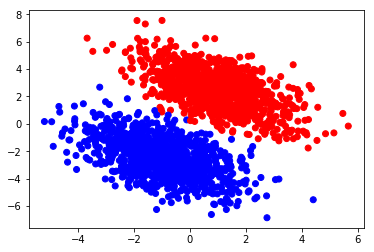

In [15]:
X = np.genfromtxt('DATA/data_linearX.csv', delimiter=',')
y = np.genfromtxt('DATA/data_lineary.csv', delimiter=',').astype(np.int64)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr)

X, X_test, y, y_test = train_test_split(X,y, test_size = 0.2)

The scatter plot shows that this is a linearly separable case

We would not need a lot of epochs to come up with suitable weights as the space is linearly separable. As a result, I have restricted the number of epochs to be low : 500.

Having higher number of epochs can lead to overfitting. 

Error in test set is  0.75 %


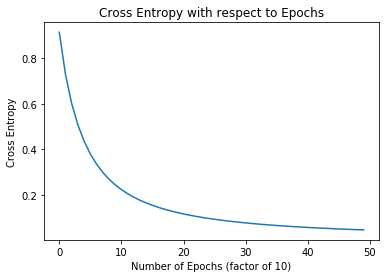

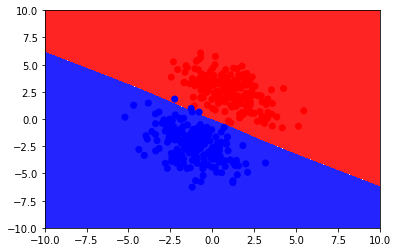

Confusion Matrix 

[[205   0]
 [  3 192]]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99       205
          1       1.00      0.98      0.99       195

avg / total       0.99      0.99      0.99       400



In [16]:
m = X.shape[0]
input_dim = int(X.shape[1])
output_dim = int(y.max() + 1)
nodes = 5

nn = one_layer_nn(input_dim,  nodes , output_dim, alpha = 0.05, num_epochs = 500)
train_err = nn.fit(X,y)

y_pred = nn.predict(X_test)

err = error_rate(y_pred,y_test)
print("Error in test set is ",err*100, "%")

plt.plot(train_err)
plt.title("Cross Entropy with respect to Epochs")
plt.xlabel("Number of Epochs (factor of 10)")
plt.ylabel("Cross Entropy")
plt.show()

#Even though the cross entropy is not minimized, our system is able to distinguish the red points from the blue points easily 

# Plotting decision boundary 
plot_decision_boundary(nn, X_test, y_test)

#Confusion matrix
print("Confusion Matrix \n")
print(confusion_matrix(y_pred, y_test))
print(classification_report(y_pred,y_test))

In [17]:
#Cross Validation score for the linear dataset
X = np.genfromtxt('DATA/data_linearX.csv', delimiter=',')
y = np.genfromtxt('DATA/data_lineary.csv', delimiter=',').astype(np.int64)
test_error = k_fold_cross(X,y, k = 5, nodes = 5, num_epochs = 500, alpha = 0.05)
print("Average test error is :" , test_error)

Average test error is : 0.0016666666666666668


### Non-Linear data 

We would need more epochs since the function being calculated is complex. We will explore the result of selecting different values of num_epochs and learning rate in the next section. The current hyperparameters are selected according to the 

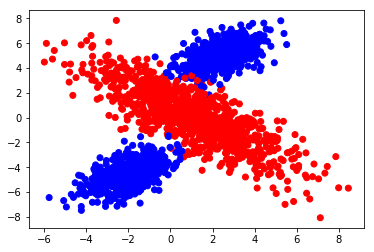

In [18]:
X = np.genfromtxt('DATA/data_nonlinearX.csv', delimiter=',')
y = np.genfromtxt('DATA/data_nonlineary.csv', delimiter=',').astype(np.int64)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr)

X, X_test, y, y_test = train_test_split(X,y, test_size = 0.2)

Error in test set is  1.25 %


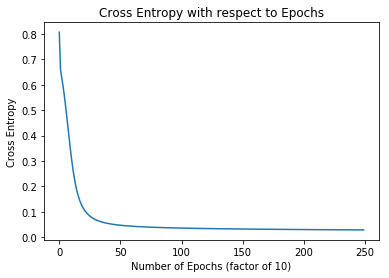

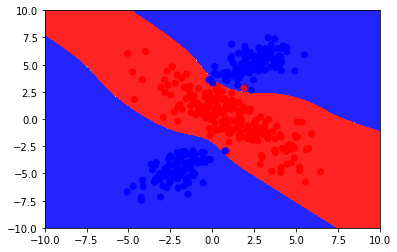

Confusion Matrix 

[[205   1]
 [  4 190]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       206
          1       0.99      0.98      0.99       194

avg / total       0.99      0.99      0.99       400



In [19]:
m = X.shape[0]
input_dim = int(X.shape[1])
output_dim = int(y.max() + 1)
nodes = 10

nn = one_layer_nn(input_dim,  nodes , output_dim, alpha = 0.5, num_epochs = 2500)
train_err = nn.fit(X,y)

y_pred = nn.predict(X_test)

err = error_rate(y_pred,y_test)
print("Error in test set is ",err*100, "%")

plt.plot(train_err)
plt.title("Cross Entropy with respect to Epochs")
plt.xlabel("Number of Epochs (factor of 10)")
plt.ylabel("Cross Entropy")
plt.show()

#Even though the cross entropy is not minimized, our system is able to distinguish the red points from the blue points easily 

# Plotting decision boundary 
plot_decision_boundary(nn, X_test, y_test)

#Confusion matrix
print("Confusion Matrix \n")
print(confusion_matrix(y_pred, y_test))
print(classification_report(y_pred,y_test))

In [20]:
#Cross Validation score for the linear dataset
X = np.genfromtxt('DATA/data_nonlinearX.csv', delimiter=',')
y = np.genfromtxt('DATA/data_nonlineary.csv', delimiter=',').astype(np.int64)
test_error = k_fold_cross(X,y, k = 5, nodes = 10, num_epochs = 2500, alpha = 0.05)
print("Average test error is :" , test_error)

Average test error is : 0.01


### Learning rate



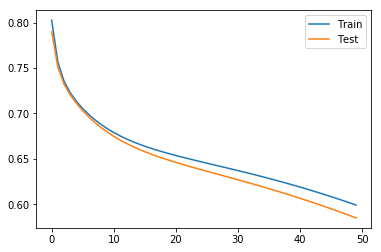

In [21]:
#Script for checking the test and train error
X = np.genfromtxt('DATA/data_nonlinearX.csv', delimiter=',')
y = np.genfromtxt('DATA/data_nonlineary.csv', delimiter=',').astype(np.int64)
m = X.shape[0]
input_dim = int(X.shape[1])
output_dim = int(y.max() + 1)
nodes = 10 

nn = one_layer_nn(input_dim,  nodes , output_dim, alpha = 0.05, num_epochs = 500)
X_train, X_test, y_train, y_test = train_test_split(X,y)
err = nn.fit_test_train(X_train,y_train,X_test,y_test)

train_err = err[0]
test_err  = err[1]

plt.plot(train_err)
plt.plot(test_err)
plt.legend(('Train','Test'))
plt.show()



### Regularization

What is regularization ?

Types of regularization : Any type of constrained optimization is regularization procedure. We can add a penalty in the performance function which would indicate how complex a function is. Below are most widely used method for regularizing a neural network. 

L1 Regularization 

L2 Regularization 

Dropout Regularization 


#### Implementation of L2 regularization :  
We are adding a term lambda*weight to the gradient on every term. This is used because for L2 regularization, we add lambda/2 * ( weight ) ^ 2 to the performace function. Derivative of this function wrt weight is lambda * weight. 


In [22]:
class regularized_one_layer_nn (one_layer_nn):
    
    def __init__(self,input_dim, nodes, output_dim , alpha = 0.1, num_epochs =1000,reg_para=0.001):
        self.reg   = reg_para
        super().__init__(input_dim, nodes, output_dim ,alpha, num_epochs)

    def hyperparameter(self, alpha, num_epochs , reg_para ):
        self.alpha = alpha
        self.num_epochs = num_epochs
        self.reg = reg_para
    
    def update_weight (self, grads):
        #Adding derivative of regularization term
        self.bias_hidden -= self.reg*self.bias_hidden
        self.bias_output -= self.reg*self.bias_output
        self.theta_hidden-= self.reg*self.theta_hidden
        self.theta_output-= self.reg*self.theta_output
        
        self.bias_hidden -= self.alpha*grads["bi_hid"] 
        self.bias_output -= self.alpha*grads["bi_op"]
        self.theta_hidden -= self.alpha*grads["th_hid"]
        self.theta_output -= self.alpha*grads["th_op"]


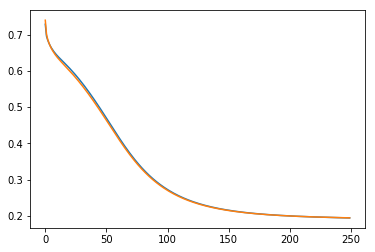

In [24]:
nn = regularized_one_layer_nn( input_dim,  nodes , output_dim, alpha = 0.1, num_epochs = 2500 )
X_train, X_test, y_train, y_test = train_test_split(X,y)
err = nn.fit_test_train(X_train,y_train,X_test,y_test)

train_err = err[0]
test_err = err[1]

plt.plot(train_err)
plt.plot(test_err)
plt.show()

### Digit Recognition

We have taken a neural network with more than 10 nodes in the layer. If we tke less than 10, the network will have to share computations, which may lead to poor performance. 

In [26]:
X = np.genfromtxt('DATA/Digit_X_train.csv', delimiter=',')
y = np.genfromtxt('DATA/Digit_y_train.csv', delimiter=',').astype(np.int64)
m = X.shape[0]
input_dim = int(X.shape[1])
output_dim = int(y.max() + 1)
nodes = 20

nn = one_layer_nn(input_dim,  nodes , output_dim, alpha = 0.5, num_epochs = 5000)
train_err = nn.fit(X,y)
train_err.pop(0)

X_test = np.genfromtxt('DATA/Digit_X_test.csv', delimiter=',')
y_test = np.genfromtxt('DATA/Digit_y_test.csv', delimiter=',').astype(np.int64)

y_pred = nn.predict(X_test)

err = error_rate(y_pred,y_test)
